In [291]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator
from sklearn.linear_model import LinearRegression
import math
%matplotlib inline

For each day, we count the searches mapped to each of these symptoms and organize the data by geographic region. The resulting dataset is a daily or weekly time series for each region showing the relative frequency of searches for each symptom.

## Preparing Dataset

In [6]:
F = pd.read_csv('data/current/2020_country_daily_2020_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F.columns = ['date', 'open_covid_region_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F = F[F['open_covid_region_code'].notna()]
F = F.sort_values(by=['open_covid_region_code'])
F = F.fillna(0)

In [7]:
F_2021 = pd.read_csv('data/current/2021_country_daily_2021_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F_2021.columns = ['date', 'open_covid_region_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F_2021 = F_2021[F_2021['open_covid_region_code'].notna()]
F_2021 = F_2021.sort_values(by=['open_covid_region_code'])
F_2021 = F_2021.fillna(0)

In [224]:
actual_cases = pd.read_csv('data/all-states-history.csv')[['date','state','positiveIncrease']]

In [225]:
# EXLCUDING: AS(America Samoa), GU(Guam), MP(Northern Mariana Islands), PR(Puerto Rico), VI(Virgin Islands)
OVERLAPPING_STATES = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 
                      'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 
                      'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 
                      'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
actual_cases = actual_cases[actual_cases['state'].isin(OVERLAPPING_STATES)]
unique_dates = actual_cases['date'].unique()
lacking = []
for date in unique_dates:
    if len(actual_cases[actual_cases.date == date]) == 51:
        continue
    else: 
        lacking.append(date)
print("last date without full 51 states: ", max(lacking))
actual_cases = actual_cases[actual_cases.date > '2020-03-06']

last date without full 51 states:  2020-03-06


#### Actual Data for Testing

In [231]:
actual_cases_testing = pd.read_csv('data/all-states-history_till_MARCH.csv')[['date','state','positiveIncrease']]
actual_cases_testing = actual_cases_testing[actual_cases_testing['state'].isin(OVERLAPPING_STATES)]
unique_dates = actual_cases_testing['date'].unique()
lacking = []
for date in unique_dates:
    if len(actual_cases_testing[actual_cases_testing.date == date]) == 51:
        continue
    else: 
        lacking.append(date)
print("last date without full 51 states: ", max(lacking))
actual_cases_testing = actual_cases_testing[actual_cases_testing.date > '2020-03-06']
print("max day is", max(actual_cases_testing.date))

last date without full 51 states:  2020-03-06
max day is 2021-03-07


Checking new data

In [11]:
NUM_STATES = F.open_covid_region_code.nunique()
assert NUM_STATES == 51, "NUM_STATES ERROR"
STATES = F.open_covid_region_code.unique()
SYMP_LIST = ['symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 
             'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 
             'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 
             'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
NUM_SYMP = len(SYMP_LIST)
assert NUM_SYMP == 17, "NUM SYMP ERROR"

In [12]:
BORDER_DICT = {
    'US-AK': [],
    'US-AL': ['US-MI', 'US-TN', 'US-GA', 'US-FL'],
    'US-AR': ['US-OK', 'US-TX', 'US-MO', 'US-TN', 'US-MS', 'US-LA'],
    'US-AZ': ['US-NM', 'US-UT', 'US-NV', 'US-CA'],
    'US-CA': ['US-OR', 'US-NV', 'US-AZ'],
    'US-CO': ['US-WY', 'US-NE', 'US-KS', 'US-OK', 'US-NM', 'US-UT'],
    'US-CT': ['US-RI', 'US-MA', 'US-NY'],
    'US-DC': ['US-MD', 'US-VA'],
    'US-DE': ['US-PA', 'US-NJ', 'US-MD'],
    'US-FL': ['US-AL', 'US-GA'],
    'US-GA': ['US-FL', 'US-AL', 'US-TN', 'US-NC', 'US-SC'],
    'US-HI': [],
    'US-IA': ['US-MN', 'US-WI', 'US-IL', 'US-MO', 'US-NE', 'US-SD'],
    'US-ID': ['US-OR', 'US-NV', 'US-UT', 'US-WY', 'US-MT', 'US-WA'],
    'US-IL': ['US-IA', 'US-MO', 'US-KY', 'US-IN', 'US-WI'],
    'US-IN': ['US-MI', 'US-OH', 'US-KY', 'US-LI'],
    'US-KS': ['US-CO', 'US-NE', 'US-MO', 'US-OK'],
    'US-KY': ['US-IL', 'US-IN', 'US-OH', 'US-WV', 'US-VA', 'US-TN', 'US-MO'],
    'US-LA': ['US-TX', 'US-AR', 'US-MS'],
    'US-MA': ['US-NH', 'US-VT', 'US-NY', 'US-RI', 'US-CT'],
    'US-MD': ['US-DE', 'US-VA', 'US-WV', 'US-PA'],
    'US-ME': ['US-NH'],
    'US-MI': ['US-WI', 'US-IN', 'US-OH'],
    'US-MN': ['US-ND', 'US-SD', 'US-IA', 'US-WI'],
    'US-MO': ['US-IA', 'US-IL', 'US-KY', 'US-TN', 'US-AR', 'US-OK', 'US-KS', 'US-NE'], 
    'US-MS': ['US-AL', 'US-TN', 'US-AR', 'US-LA'],
    'US-MT': ['US-ID', 'US-WY', 'US-SD', 'US-ND'],
    'US-NC': ['US-VA', 'US-TN', 'US-GA', 'US-SC'],
    'US-ND': ['US-MT', 'US-SD', 'US-MN'],
    'US-NE': ['US-SD', 'US-IA', 'US-MO', 'US-KS', 'US-CO', 'US-WY'],
    'US-NH': ['US-ME', 'US-VT', 'US-MA'],
    'US-NJ': ['US-PA', 'US-DE', 'US-NY'],
    'US-NM': ['US-AZ', 'US-CO', 'US-OK', 'US-TX'],
    'US-NV': ['US-CA', 'US-OR', 'US-ID', 'US-UT', 'US-AZ'],
    'US-NY': ['US-VT', 'US-MA', 'US-CT', 'US-NJ', 'US-PA'],
    'US-OH': ['US-MI', 'US-IN', 'US-KY', 'US-WV', 'US-PA'],
    'US-OK': ['US-TX', 'US-AR', 'US-MO', 'US-KS', 'US-CO', 'US-NM'],
    'US-OR': ['US-WA', 'US-ID', 'US-NV', 'US-CA'],
    'US-PA': ['US-NJ', 'US-NY', 'US-DE', 'US-MD', 'US-WV', 'US-OH'], 
    'US-RI': ['US-MA', 'US-CT'],
    'US-SC': ['US-NC', 'US-GA'],
    'US-SD': ['US-ND', 'US-MN', 'US-IA', 'US-NE', 'US-WY', 'US-MT'], 
    'US-TN': ['US-KY', 'US-VA', 'US-NC', 'US-GA', 'US-AL', 'US-MS', 'US-AR', 'US-MO'],
    'US-TX': ['US-NM', 'US-OK', 'US-AR', 'US-LA'],
    'US-UT': ['US-NV', 'US-AZ', 'US-CO', 'US-WY', 'US-ID'],
    'US-VA': ['US-WV', 'US-MD', 'US-KY', 'US-TN', 'US-NC'], 
    'US-VT': ['US-NH', 'US-MA', 'US-NY'],
    'US-WA': ['US-OR', 'US-ID'],
    'US-WI': ['US-MI', 'US-IL', 'US-IA', 'US-MN'],
    'US-WV': ['US-OH', 'US-PA', 'US-MD', 'US-VA'],
    'US-WY': ['US-ID', 'US-MT', 'US-SD', 'US-NE', 'US-CO', 'US-UT']
}

## Obtaining Weights & Intercept

In [13]:
# ctrl_region_symp (Fsdn), Ysdn
# target_region_symp (Fsdrt)
def beta(ctrl_region_symp, Ysdn):
    numerator = NUM_SYMP * np.sum(np.multiply(ctrl_region_symp,Ysdn)) - (np.multiply(np.sum(ctrl_region_symp), np.sum(Ysdn)))
    denominator = NUM_SYMP * np.sum(np.square(ctrl_region_symp)) - np.square(np.sum(ctrl_region_symp))
    return numerator / denominator

def epsilon(ctrl_region_symp, Ysdn, beta):
    numerator = np.sum(Ysdn) - (beta * np.sum(ctrl_region_symp))
    return numerator / NUM_SYMP

def R2(e2_list, target_region_symp, mean_symp_rate):
#     mean_symp_rate = np.mean(target_region_symp)
    numerator = np.sum(e2_list)
    denominator = np.sum(np.square(target_region_symp - mean_symp_rate))
    return 1 - (numerator/denominator)

# Returns an array of control states
def get_ctrl_states(target_region):
    index = np.where(STATES != target_region)
    ctrl_states_pool = STATES[index]
    ctrl_states_pool = np.setdiff1d(ctrl_states_pool, BORDER_DICT[target_region])
    return ctrl_states_pool

In [14]:
# F_data = F filtered down to a single date
# data = F_data without target region row

def obtain_weights(F_data, target_region):
    CTRL_REGIONS = get_ctrl_states(target_region)
    data = F_data[F_data.open_covid_region_code.isin(CTRL_REGIONS)]

    target_region = F_data[F_data.open_covid_region_code == target_region]
    target_region_symp_rates = target_region[SYMP_LIST].to_numpy().flatten()
    mean_target_symp_rates = np.mean(target_region_symp_rates)
    
    best_ctrl_region_list = []
    beta_control = np.zeros(5)
    epsilon_control = np.zeros(5)
    mju_list = np.zeros((5, NUM_SYMP))
    best_e2 = np.zeros(5)
    
    for n in range(5):
        R2_list = np.zeros(len(CTRL_REGIONS))
        
        Ysdn = target_region_symp_rates - mju_list[n-1]
        mean_Ysdn = np.mean(Ysdn)
        beta_list = np.zeros(len(CTRL_REGIONS))
        epsilon_list = np.zeros(len(CTRL_REGIONS))
        
        for idx_r, region in enumerate(CTRL_REGIONS):
            region_row = data[data.open_covid_region_code == region]
            region_symp_rates = region_row[SYMP_LIST].to_numpy().flatten()
            
            beta_region = beta(region_symp_rates, Ysdn)
            epsilon_region = epsilon(region_symp_rates, Ysdn, beta_region)
            beta_list[idx_r] = beta_region
            epsilon_list[idx_r] = epsilon_region
                   
            F_hat_s = np.multiply(beta_region, region_symp_rates) + epsilon_region
            e2_list = np.square(Ysdn - F_hat_s)
            
            R2_region = R2(e2_list, Ysdn, mean_Ysdn)
            R2_list[idx_r] = R2_region
        
        best_ctrl_region_idx = R2_list.argmax()
        best_ctrl_region_list.append(CTRL_REGIONS[best_ctrl_region_idx])
        
        CTRL_REGIONS = np.delete(CTRL_REGIONS, best_ctrl_region_idx)
        
        beta_control[n] = beta_list[best_ctrl_region_idx]
        epsilon_control[n] = epsilon_list[best_ctrl_region_idx]
        
        best_region_row = data[data.open_covid_region_code == best_ctrl_region_list[-1]]
        best_region_row = best_region_row[SYMP_LIST].to_numpy().flatten()
        F_hat_s = np.multiply(beta_control[n], best_region_row) + epsilon_control[n]
        
        mju_list[n] = F_hat_s + mju_list[n-1]
        e2 = np.sum(np.square(Ysdn - F_hat_s))
        best_e2[n] = e2
    return best_ctrl_region_list, beta_control, epsilon_control, best_e2
   

### Predicting Symptom Rates

In [15]:
def pred_single_symp_rate(F_data_symp, best_ctrl_regions, beta_control, epsilon_control):
    # F_data_symp = F filtered down to a single date & single symptom column
    F_hat_s = 0
    for i in range(5):
        ctrl_region_symp_rate = F_data_symp[F_data_symp.open_covid_region_code == best_ctrl_regions[i]].to_numpy().flatten()[1] 
        F_hat_s = F_hat_s + beta_control[i] * ctrl_region_symp_rate
    F_hat_s = F_hat_s + np.sum(epsilon_control)
    return F_hat_s

def pred_all_symp_rates(F, date, best_ctrl_regions, beta_control, epsilon_control):
    # Prediction of all 17 symptoms of target region 
    F_data = F[F.date == date]
    F_hat_s_list = np.zeros(NUM_SYMP)
    for idx_s, symp in enumerate(SYMP_LIST):
        F_data_symp = F_data[['open_covid_region_code', symp]]
        F_hat_s = pred_single_symp_rate(F_data_symp, best_ctrl_regions, beta_control, epsilon_control)
        F_hat_s_list[idx_s] = F_hat_s
    return F_hat_s_list

# delta is [17,1]
def delta_symp(ground_truth_symp_rates, pred_symp_rates):
    delta = np.subtract(ground_truth_symp_rates, pred_symp_rates)
    return delta

In [16]:
def get_date(date):
    date_elems = [int(elem) for elem in date.split('-')]
    return datetime.datetime(date_elems[0], date_elems[1], date_elems[2])

# Extend start date back by one day for obtaining weights 
def prepare_date_range(start_date, end_date):
    start = get_date(start_date) + datetime.timedelta(days=-1)
    end = get_date(end_date)
    date_range = list(pd.date_range(start, end))
    date_range = [date.strftime('%Y-%m-%d') for date in date_range]
    return date_range

In [17]:
# Should return Delta Matrix = [period, region, symptoms]
def symptom_rate_pred_model(F, start_date, end_date):
    # date_range includes one extra day in the beginning 
    date_range = prepare_date_range(start_date, end_date)
    period = len(date_range)
    delta_mat = np.zeros((period, NUM_STATES, NUM_SYMP))
    
    # date_range[0] is first obtain weights date: start_date - 1
    # date_range[1] is first day of predictions, date_range[-1] is last day of predictions
    for idx_d, date in enumerate(date_range[:period-1]):
        pred_date = date_range[idx_d+1]
        # delta array of 51 states and their 17 symptoms on 1 day
        delta_day = np.zeros((NUM_STATES, NUM_SYMP))
        query_date_data = F[F.date == pred_date]
        obtain_weight_date = F[F.date == date]
        for idx_r, region in enumerate(STATES):
            actual_symp_rates = query_date_data[query_date_data.open_covid_region_code == region]
            best_ctrl_region_list, beta_control, epsilon_control, best_e2 = obtain_weights(obtain_weight_date, region)   

            F_hat_s_list = pred_all_symp_rates(F, pred_date, best_ctrl_region_list, beta_control, epsilon_control)
            actual_queries = actual_symp_rates.drop(['date', 'open_covid_region_code'], axis = 1).to_numpy().flatten()
            delta_region = delta_symp(actual_queries, F_hat_s_list)
     
            delta_day[idx_r] = delta_region      
        delta_mat[idx_d] = delta_day
    return delta_mat, period

### FROM HERE ON:
We are only looking at delta symptom: COUGH (idx 4) * FEVER (idx 7)

In [18]:
# New delta shape (period, region)
NEW_NUM_SYMP = 1
def new_delta_mat(delta_mat, period, idx_symp1, idx_symp2):
    new_delta_mat = np.zeros((period, NUM_STATES))
    for idx_d in range(period):
        # delta day shape (51,)
        delta_day = delta_mat[idx_d]
        delta_symp_1_2 = np.array([ np.multiply(delta_region[idx_symp1], delta_region[idx_symp2]) for delta_region in delta_day])
        new_delta_mat[idx_d] = delta_symp_1_2
    return new_delta_mat

# Symptom Rates Outbreak Detection

In [19]:
# Average delta of all days for each region
# delta mat shape (period, region)

def average_delta(period, delta_mat):
    ave_mat = np.zeros(NUM_STATES)
    for idx_r, delta_region in enumerate(delta_mat.transpose()):
        ave_region = np.mean(delta_region)
        ave_mat[idx_r] = ave_region
    return ave_mat

def std_dev_delta(period, delta_mat):
    std_mat = np.zeros(NUM_STATES)
    for idx_r, delta_region in enumerate(delta_mat.transpose()):
        std_region = np.std(delta_region)
        std_mat[idx_r] = std_region
    return std_mat

def z_score(delta_mat, ave_mat, std_mat, period):
    z_score = np.zeros((period, NUM_STATES))
    for idx_d, delta_day in enumerate(delta_mat):
        z_day = np.divide(np.subtract(delta_day, ave_mat), std_mat)
        z_score[idx_d] = z_day
    return z_score

def L_score(z_score, TH):
    L_score = z_score > TH
    return L_score.astype(int)

In [20]:
# period is the number of days that there are predictions (not including extra day for obtaining weights)
def pred_outbreak_detection(delta_mat, period, TH):
    ave_mat = average_delta(period, delta_mat)
    std_mat = std_dev_delta(period, delta_mat)
    z = z_score(delta_mat, ave_mat, std_mat, period)
    l_score = L_score(z, TH)
    return l_score

## Actual Outbreak Detection - INCLUDES LOW CASE COUNT ANOMALIES

In [128]:
# FOR WHOLE Period
def covid_case_outbreak_detection_all(X, target_region):
    X_target = X[X.state == target_region].drop(['date', 'state'], axis=1).to_numpy().flatten()
    X_target[X_target < 1] = 1
    assert np.any(X_target < 1) == False, "Actual Cases < 1"
    
    period = len(X_target)
    C = np.zeros(period)
    for idx, X_day in enumerate(X_target):
        if idx == 0:
            continue  
        Cd = np.divide(np.subtract(X_day, X_target[idx-1]), X_target[idx-1])
        C[idx] = Cd
    std_C = np.std(C)
    C[C > (3 * std_C)] = 0
    std_C = np.std(C)
    L_score = C > (2 * std_C)
    return L_score.astype(int)

## Comparison

__L__ is Actual __L_hat__ is Symp Rate Outbreak

In [141]:
def get_target_region_idx(target_region):
    i, = np.where(STATES == target_region)
    return i.item()

def window_L(L, lag, period_L_hat):
    idx = np.arange(lag, lag + period_L_hat)
    L_window = L[idx]
    return L_window

def comparison_all(target_region, L, L_hat, lag):
    target_reg_idx = get_target_region_idx(target_region)
    L_hat_region = L_hat.transpose()[target_reg_idx]
    period = L_hat.shape[0]
    assert len(L_hat_region) == period, "L_hat_region size issue"
    
    L_window = window_L(L, lag, period)
    Lw = np.zeros(7)
    S = np.zeros((period, 2))
    
    counted = []
    for idx_L, L_hat_day in enumerate(L_hat_region): 
        # w holds date indexes of L_window to be compared w L_hat
        if idx_L < 3: 
            w = np.arange(0, (idx_L+4))
        elif idx_L >= (period-3):
            w = np.arange((idx_L-3), period)
        else: 
            w = np.arange((idx_L-3), (idx_L+4))
        
        Lw = L_window[w]
        s = np.zeros(2)
        if L_hat_day == 1:
            # Is there an outbreak in the Lw window? Get position of outbreak in window
            L_outbreaks = np.argwhere(Lw == 1).flatten()
            # Get outbreak date index
            date_idx_L_outbreaks = w[L_outbreaks]
            # Check to see if the indexes of outbreak dates has been counted. 
            new_outbreaks = np.setdiff1d(date_idx_L_outbreaks, np.array(counted))
            if new_outbreaks.shape[0] > 0:
                idx_outbreak = new_outbreaks[0]
                s[0] = 1
                counted.append(idx_outbreak)
            else:
                s[1] = 1
        S[idx_L] = s
    return S, L_window

In [294]:
def metrics(S, L_window):
    TP_FP = np.sum(S, axis=0)
    FN = np.sum(L_window) - TP_FP[0]
    precision = TP_FP[0] / (TP_FP[0] + TP_FP[1])
    recall = TP_FP[0] / (TP_FP[0] + FN)
    Fscore = 2 * ((precision * recall) / (precision + recall))
    if math.isnan(Fscore) == True:
        print("NAN!")
        print(precision)
        print(recall)
    return TP_FP, FN, precision, recall, Fscore

# Loading Delta Data & Creating New Signal: Cough x Fever

In [24]:
from numpy import load
data_Jan = load('results/delta/Jan_02_31.npy')
data_Feb = load('results/delta/Feb_01_29.npy')
data_Mar = load('results/delta/Mar_01_31.npy')
data_Apr = load('results/delta/Apr_01_30.npy')
data_May = load('results/delta/May_01_31.npy')
data_Jun = load('results/delta/June_01_30.npy')
data_Jul = load('results/delta/Jul_01_31.npy')
data_Aug = load('results/delta/Aug_01_31.npy')
data_Sept = load('results/delta/Sept_01_30.npy')
data_Oct = load('results/delta/Oct_01_31.npy')
data_Nov = load('results/delta/Nov_01_30.npy')
data_Dec = load('results/delta/Dec_01_31.npy')
data_Jan21 = load('results/delta/Jan21_01_31.npy')
data_Feb21 = load('results/delta/Feb21_01_23.npy')

period_jan = data_Jan.shape[0]
period_feb = data_Feb.shape[0]
period_nov = data_Nov.shape[0]
period_31 = data_Mar.shape[0]
period_30 = data_Apr.shape[0]
period_feb = data_Feb21.shape[0]

# Where only considering Cough x Fever 
# MARCH STARTS ON 7th 
new_delta_Mar = new_delta_mat(data_Mar, period_31, 4, 7)[6:]
new_delta_Apr = new_delta_mat(data_Apr, period_30, 4, 7)
new_delta_May = new_delta_mat(data_May, period_31, 4, 7)
new_delta_Jun = new_delta_mat(data_Jun, period_30, 4, 7)
new_delta_Jul = new_delta_mat(data_Jul, period_31, 4, 7)
new_delta_Aug = new_delta_mat(data_Aug, period_31, 4, 7)
new_delta_Sept = new_delta_mat(data_Sept, period_30, 4, 7)
new_delta_Oct = new_delta_mat(data_Oct, period_31, 4, 7)
new_delta_Nov = new_delta_mat(data_Nov, period_30, 4, 7)
new_delta_Dec = new_delta_mat(data_Dec, period_31, 4, 7)
new_delta_Jan21 = new_delta_mat(data_Jan21, period_31, 4, 7)
new_delta_Feb21 = new_delta_mat(data_Feb21, period_feb, 4, 7)

In [25]:
# Joining of new delta: 7th Mar - Jan 2021
new_delta = np.concatenate((new_delta_Mar, new_delta_Apr), axis=0)
new_delta = np.concatenate((new_delta, new_delta_May), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Jun), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Jul), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Aug), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Sept), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Oct), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Nov), axis=0)
new_delta = np.concatenate((new_delta, new_delta_Dec), axis=0)
# new_delta_mar_jan = np.concatenate((new_delta_mar_feb, new_delta_Jan21), axis=0)
# new_delta_mar_feb = np.concatenate((new_delta_mar_feb, new_delta_Feb21), axis=0)

# March 7th - 31 Dec 2020
L_hat_period_all = new_delta.shape[0]
print(L_hat_period_all)

300


## Actual Cases

In [26]:
#INCLUDE PREVIOUS DAY FOR FIRST DAY OF EACH MONTH
# actual_mar has 25 days (starting 7th)
actual_mar = actual_cases[(actual_cases.date >= '2020-03-07') & (actual_cases.date <= '2020-03-31')]
actual_apr = actual_cases[(actual_cases.date >= '2020-03-31') & (actual_cases.date <= '2020-04-30')]
actual_may = actual_cases[(actual_cases.date >= '2020-04-30') & (actual_cases.date <= '2020-05-31')]
actual_jun = actual_cases[(actual_cases.date >= '2020-05-31') & (actual_cases.date <= '2020-06-30')]
actual_jul = actual_cases[(actual_cases.date >= '2020-06-30') & (actual_cases.date <= '2020-07-31')]
actual_aug = actual_cases[(actual_cases.date >= '2020-07-31') & (actual_cases.date <= '2020-08-31')]
actual_sept = actual_cases[(actual_cases.date >= '2020-08-31') & (actual_cases.date <= '2020-09-30')]
actual_oct = actual_cases[(actual_cases.date >= '2020-09-30') & (actual_cases.date <= '2020-10-31')]
actual_nov = actual_cases[(actual_cases.date >= '2020-10-31') & (actual_cases.date <= '2020-11-30')]
actual_dec = actual_cases[(actual_cases.date >= '2020-11-30') & (actual_cases.date <= '2020-12-31')]
actual_jan21 = actual_cases[(actual_cases.date >= '2020-12-31') & (actual_cases.date <= '2021-01-31')]

# 30 days before 2021-02-23 is 2021-01-24
actual_all = actual_cases[(actual_cases.date >= '2020-03-01') & (actual_cases.date <= '2021-02-23')]

In [27]:
print("L")
print(min(actual_all.date))
print(max(actual_all.date))
print()
print("L_hat")
print("2020-03-07")
print("2020-12-31")

L
2020-03-07
2021-02-23

L_hat
2020-03-07
2020-12-31


# Testing

## Preparing Data: L HAT

Testing period: 1 Jan 2021 - 5 February 2021 (36 days)

In [278]:
new_delta_testing = np.concatenate((new_delta_Jan21, new_delta_Feb21[:5]), axis=0)
testing_period = len(new_delta_testing)
print(testing_period, "days")

test_ave_mat = average_delta(testing_period, new_delta_testing)
test_std_mat = std_dev_delta(testing_period, new_delta_testing)

36 days


In [267]:
actual_testing = actual_cases_testing[(actual_cases_testing.date >= "2020-12-31") & (actual_cases_testing.date <= "2021-03-07")]
print(actual_testing.date.nunique(), "days")
#REMEMBER TO EXCLUDE L[0]! (31st Dec 2020)

67 days


(66,)

In [307]:
def z_score_test(delta_region_day, ave, std, period):
    z_score = np.zeros(period)
    for idx_d, delta in enumerate(delta_region_day):
        z_day = np.divide(np.subtract(delta, ave), std)
        z_score[idx_d] = z_day
    return z_score

def comparison_test(L, L_hat_region, lag):
    period = len(L_hat_region) 
    L_window = window_L(L, lag, period)
    Lw = np.zeros(7)
    S = np.zeros((period, 2))
    counted = []
    for idx_L, L_hat_day in enumerate(L_hat_region): 
        if idx_L < 3: 
            w = np.arange(0, (idx_L+4))
        elif idx_L >= (period-3):
            w = np.arange((idx_L-3), period)
        else: 
            w = np.arange((idx_L-3), (idx_L+4))
        Lw = L_window[w]
        s = np.zeros(2)
        if L_hat_day == 1:
            # Is there an outbreak in the Lw window? Get position of outbreak in window
            L_outbreaks = np.argwhere(Lw == 1).flatten()
            # Get outbreak date index
            date_idx_L_outbreaks = w[L_outbreaks]
            # Check to see if the indexes of outbreak dates has been counted. 
            new_outbreaks = np.setdiff1d(date_idx_L_outbreaks, np.array(counted))
            if new_outbreaks.shape[0] > 0:
                idx_outbreak = new_outbreaks[0]
                s[0] = 1
                counted.append(idx_outbreak)
            else:
                s[1] = 1
        S[idx_L] = s
    return S, L_window

def test(test_delta, actual_testing, testing_period, ave_mat, std_mat, best_th_lag):
    f_score = np.zeros(NUM_STATES)
    TP_FP = np.zeros((NUM_STATES,2))
    FN = np.zeros(NUM_STATES)
    
    true_anomalies = np.zeros(NUM_STATES)
    for idx_s, state in enumerate(STATES):
        target = state[3:]
        L_test = covid_case_outbreak_detection_all(actual_testing, target)[1:]
        assert L_test.shape[0] == testing_period + 30, "L length issue"
        
        test_delta_region = test_delta.transpose()[idx_s]
        z_score_region = z_score_test(test_delta_region, ave_mat[idx_s], std_mat[idx_s], testing_period)
        L_hat_testing = L_score(z_score_region, best_th_lag[idx_s][0]) 
        
        S_test, L_window_test = comparison_test(L_test, L_hat_testing, int(best_th_lag[idx_s][1]))
        met = metrics(S_test, L_window_test)
        
        true_anomalies[idx_s] = np.sum(L_window_test)
        f_score[idx_s] = met[4]
        TP_FP[idx_s] = met[0]
        FN[idx_s] = met[1]
    return f_score, TP_FP, FN, true_anomalies

# EXPERIMENTATION 1

Parameters:
Target State: CA | 07 March 2020 - 31 Jan 2021 | TH = 0.1 | Lag: 0 days

- Strict matching
- low case count anomalies included
- no smoothing

### L: Actual Outbreak Detection using CA as Target & L_hat: Symptom Rate Outbreak

Window into the first 30 days (TH = 0)

Total PRED outbreaks 14


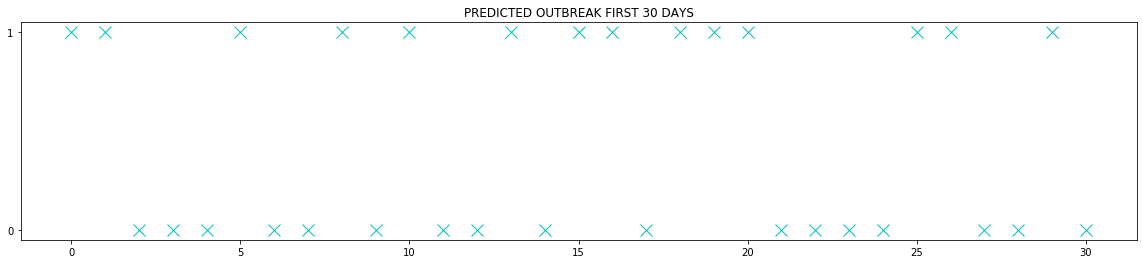

In [139]:
L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, 0)
target_idx = get_target_region_idx("US-AK")
# CHANGE INDEX TO CHANGE STATE
L_hat_region = L_hat.transpose()[target_idx]
L_hat_region_small = L_hat_region[:31]

print("Total PRED outbreaks", np.sum(L_hat_region_small))

fig, ax = plt.subplots(1, 1)
plt.setp(ax, yticks=[0, 1])
fig.set_figheight(4)
fig.set_figwidth(20)
ax.set_title('PREDICTED OUTBREAK FIRST 30 DAYS')

all = ax.plot(np.array(range(len(L_hat_region_small))),L_hat_region_small, marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')

Total REAL outbreaks 3


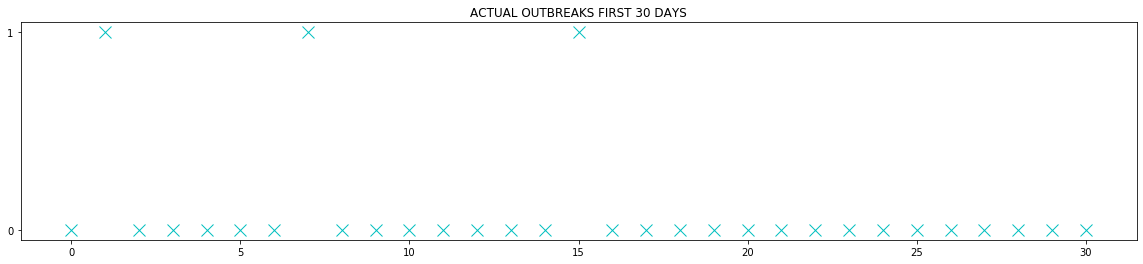

In [140]:
# L = covid_case_outbreak_detection(actual_all, 'AK')
L = covid_case_outbreak_detection_all(actual_all, 'AK')
L_small = L[0:31]
print("Total REAL outbreaks", np.sum(L_small))

fig, ax = plt.subplots(1, 1)
plt.setp(ax, yticks=[0, 1])
fig.set_figheight(4)
fig.set_figwidth(20)
ax.set_title('ACTUAL OUTBREAKS FIRST 30 DAYS')

all = ax.plot(np.array(range(len(L_small))),L_small, marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')

#### Comparison & Metrics

#### Getting the optimum lag for each state 

In [143]:
# return TP_FP, FN, precision, recall, Fscore
TH = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
# TH = 0
lag = np.arange(0,31)
state_best_th_lag = np.zeros((NUM_STATES,2))

for idx_s, state in enumerate(STATES):
    best_th_lag = np.zeros(2)
    best_lag = 0
    best_f_score = 0
    target = state[3:]
    L = covid_case_outbreak_detection_all(actual_all, target)
    for idx_th, th in enumerate(TH):
        for idx_l, l in enumerate(lag):   
            
            L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, th)
            all_S, L_window = comparison_all(state, L, L_hat, l)
            metr = metrics(all_S, L_window)
            
            if metr[4] > best_f_score:
                best_th_lag[0] = th
                best_th_lag[1] = l
                best_f_score = metr[4]
                
    state_best_th_lag[idx_s] = best_th_lag

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


#### Metrics based on optimum lag and (state_best_th_lag)

In [152]:
state_TP_FP = np.zeros((NUM_STATES,2))
state_FN = np.zeros(NUM_STATES)
state_fscore = np.zeros(NUM_STATES)
state_precision = np.zeros(NUM_STATES)
state_recall = np.zeros(NUM_STATES)

total_real_anomalies = np.zeros(NUM_STATES)

for idx_s, state in enumerate(STATES):
    target = state[3:]    
    L = covid_case_outbreak_detection_all(actual_all, target)
            
    L_hat = pred_outbreak_detection(new_delta, L_hat_period_all, state_best_th_lag[idx_s][0])
    
    all_S, L_window = comparison_all(state, L, L_hat, int(state_best_th_lag[idx_s][1]))
    total_real_anomalies[idx_s] = np.sum(L_window)
    metr = metrics(all_S, L_window)
    
    state_TP_FP[idx_s] = metr[0]
    state_FN[idx_s] = metr[1]
    state_precision[idx_s] = metr[2]
    state_recall[idx_s] = metr[3]
    state_fscore[idx_s] = metr[4]

## TESTING

In [308]:
f_test, TP_FP_test, FN_test, L_window_sum = test(new_delta_testing, actual_testing, testing_period, test_ave_mat, test_std_mat, state_best_th_lag)

NAN!
0.0
0.0
NAN!
0.0
0.0
NAN!
0.0
0.0
NAN!
0.0
nan
NAN!
0.0
0.0
NAN!
0.0
nan
NAN!
0.0
0.0
NAN!
0.0
0.0
NAN!
0.0
nan
NAN!
0.0
nan
NAN!
0.0
nan
NAN!
0.0
nan
NAN!
0.0
0.0
NAN!
0.0
nan


/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [309]:
# np.savetxt("state_TP_FP.csv", state_TP_FP, delimiter=",")
# np.savetxt("state_FN.csv", state_FN, delimiter=",")
# np.savetxt("state_precision.csv", state_precision, delimiter=",")
# np.savetxt("state_recall.csv", state_recall, delimiter=",")
# np.savetxt("state_fscore.csv", state_fscore, delimiter=",")

# np.savetxt("total_real_anomalies.csv", total_real_anomalies, delimiter=",")

# np.savetxt("state_best_th_lag.csv", state_best_th_lag, delimiter=",")

# np.savetxt("f_test.csv", f_test, delimiter=",")
# np.savetxt("TP_FP_test.csv", TP_FP_test, delimiter=",")
# np.savetxt("FN_test.csv", FN_test, delimiter=",")
np.savetxt("L_window_sum.csv", L_window_sum, delimiter=",")

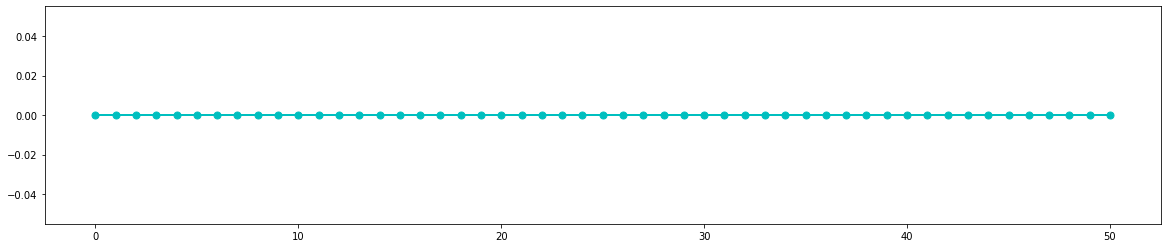

In [154]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(4)
fig.set_figwidth(20)
all = ax.plot(np.array(range(len(state_fscore))),state_fscore, marker='o',  markersize=7, color='c', linewidth=2)

# EXPERIMENTATION 2: FALSE Anomalies

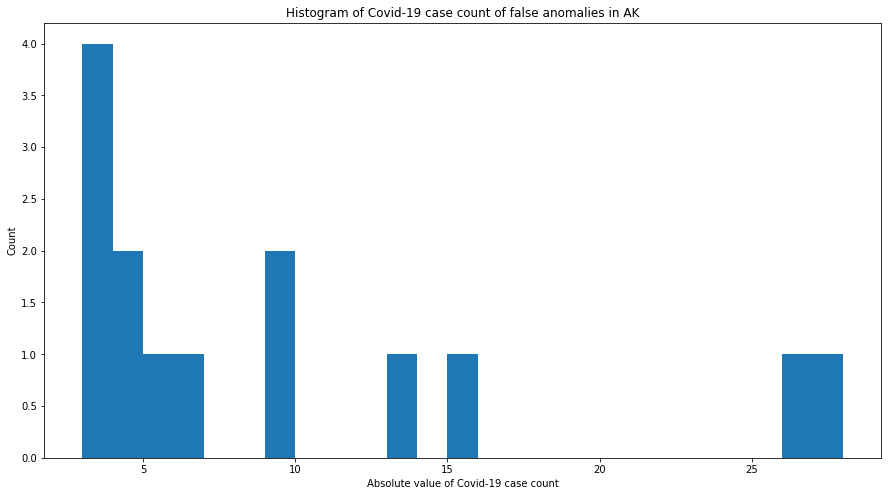

In [218]:
# Histogram purposes
def covid_case_outbreak_detection_hist(X, target_region, minimum):
    X_target = X[X.state == target_region].drop(['date', 'state'], axis=1).to_numpy().flatten()
    X_target[X_target < 1] = 1
    assert np.any(X_target < 1) == False, "Actual Cases < 1"
    
    period = len(X_target) 
    C = np.zeros(period)
    for idx, X_day in enumerate(X_target):
        if idx == 0:
            continue  
        Cd = np.divide(np.subtract(X_day, X_target[idx-1]), X_target[idx-1])
        C[idx] = Cd
        
    std_C = np.std(C)
    C[C > (3 * std_C)] = 0
    std_C = np.std(C)
    assert std_C != 0, "Std C is 0"
    L_score = C > (2 * std_C)
    L_score = L_score.astype(int)
    anomaly_cases = np.array([X_target[idx] for idx, l in enumerate(L_score) if l == 1 and X_target[idx] < minimum])
    return anomaly_cases

# FOR ALL STATES
small_anoms = np.zeros(NUM_STATES)
for idx_s, state in enumerate(STATES):
    small_anoms[idx_s] = len(covid_case_outbreak_detection_hist(actual_all, state[3:], 50))

print(small_anoms)
plt.figure(figsize=(20,8))
plt.xlabel("States")
plt.ylabel("Count of anomalies")
plt.title("Count of anomalies with an absolute case count of less than 50")
plt.bar([state[3:] for state in STATES], small_anoms)
plt.show()

# Histogram of AK
small_anoms_AK = covid_case_outbreak_detection_hist(actual_all, "AK", 50)
plt.figure(figsize=(15,8))
plt.title("Histogram of Covid-19 case count of false anomalies in AK")
plt.ylabel("Count")
plt.xlabel("Absolute value of Covid-19 case count")
plt.hist(small_anoms_AK, bins=25)
plt.show()


# Testing Symptom Rate Prediction Model

## e2 Analysis: All 51 states

In [51]:
# e2 = []
# obtain_weight_date = F[F.date == '2020-07-20']
# for s in STATES:
#     _, _, _, best_e2 = obtain_weights(obtain_weight_date, s)
#     e2.append(best_e2)

In [50]:
# n = [1,2,3,4,5]
# fig, (ax1, ax2) = plt.subplots(1, 2)

# fig.set_figheight(5)
# fig.set_figwidth(18)
# ax1.set_title('US-WA')
# ax1.plot(n, e2[47], marker='x',  markersize=12, color='c', linewidth=2, label='US-AK')
# ax1.set_ylabel('Sum of Squared Errors')
# ax1.set_xlabel('n')
# ax2.set_title('US-NY')
# ax2.plot(n, e2[34], marker='x',  markersize=12, color='c', linewidth=2, label='US-FL')
# ax2.set_ylabel('Sum of Squared Errors')
# ax2.set_xlabel('n')

# n = [1,2,3,4,5]
# fig, (ax3, ax4) = plt.subplots(1, 2)
# fig.set_figheight(5)
# fig.set_figwidth(18)
# ax3.set_title('US-TX')
# ax3.plot(n, e2[43], marker='x',  markersize=12, color='c', linewidth=2, label='US-AR')
# ax3.set_ylabel('Sum of Squared Errors')
# ax3.set_xlabel('n')
# ax4.set_title('US-CA')
# ax4.plot(n, e2[3], marker='x',  markersize=12, color='c', linewidth=2, label='US-CA')
# ax4.set_ylabel('Sum of Squared Errors')
# ax4.set_xlabel('n')

In [52]:
# fig, ax = plt.subplots(5, 2)
# plt.setp(ax, yticks=[0, 1])
# fig.set_figheight(15)
# fig.set_figwidth(20)
# ax[0,0].set_title('March - AL')
# ax[0,1].set_title('April - AL')
# ax[1,0].set_title('May - AL')
# ax[1,1].set_title('June - AL')
# ax[2,0].set_title('July - AL')
# ax[2,1].set_title('Aug - AL')
# ax[3,0].set_title('Sept - AL')
# ax[3,1].set_title('Oct - AL')
# ax[4,0].set_title('Nov - AL')

# mar = ax[0,0].plot(np.array(range(period_31)), mar_L_sr[:,4], marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')
# apr = ax[0,1].plot(np.array(range(period_30)), apr_L_sr[:,4], marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')
# may = ax[1,0].plot(np.array(range(period_31)), may_L_sr[:,4], marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')
# jun = ax[1,1].plot(np.array(range(period_30)), jun_L_sr[:,4], marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')
# jul = ax[2,0].plot(np.array(range(period_31)), jul_L_sr[:,4], marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')
# aug = ax[2,1].plot(np.array(range(period_31)), aug_L_sr[:,4], marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')
# sep = ax[3,0].plot(np.array(range(period_30)), sept_L_sr[:,4], marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')
# octo = ax[3,1].plot(np.array(range(period_31)), oct_L_sr[:,4], marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')
# nov = ax[4,0].plot(np.array(range(period_30)), nov_L_sr[:,4], marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')

In [53]:
# fig, ax = plt.subplots(1, 1)
# plt.setp(ax, yticks=[0, 1])
# fig.set_figheight(4)
# fig.set_figwidth(20)
# ax.set_title('April to Jan 21 - AL')

# all = ax.plot(np.array(range(period_all)), mar_jan_L_sr[:,4], marker='x',  markersize=12, color='c', linewidth=2, linestyle='None')

Monthlies

In [49]:
# L_mar = covid_case_outbreak_detection(actual_mar, 'CA')
# L_apr = covid_case_outbreak_detection(actual_apr, 'CA')
# L_may = covid_case_outbreak_detection(actual_may, 'CA')
# L_jun = covid_case_outbreak_detection(actual_jun, 'CA')
# L_jul = covid_case_outbreak_detection(actual_jul, 'CA')
# L_aug = covid_case_outbreak_detection(actual_aug, 'CA')
# L_sept = covid_case_outbreak_detection(actual_sept, 'CA')
# L_oct = covid_case_outbreak_detection(actual_oct, 'CA')
# L_nov = covid_case_outbreak_detection(actual_nov, 'CA')

# mar_L_hat = pred_outbreak_detection(new_delta_Mar, period_31, 0.1)
# apr_L_hat = pred_outbreak_detection(new_delta_Apr, period_30, 0.1)
# may_L_hat = pred_outbreak_detection(new_delta_May, period_31, 0.1)
# jun_L_hat = pred_outbreak_detection(new_delta_Jun, period_30, 0.1)
# jul_L_hat = pred_outbreak_detection(new_delta_Jul, period_31, 0.1)
# aug_L_hat = pred_outbreak_detection(new_delta_Aug, period_31, 0.1)
# sept_L_hat = pred_outbreak_detection(new_delta_Sept, period_30, 0.1)
# oct_L_hat = pred_outbreak_detection(new_delta_Oct, period_31, 0.1)
# nov_L_hat = pred_outbreak_detection(new_delta_Nov, period_30, 0.1)

In [48]:
# X is a dataframe
# Actual Oubreak for a SINGLE target region
# For a SINGLE month which includes the last date of previous month

# def covid_case_outbreak_detection(X, target_region):
#     X_target = X[X.state == target_region].drop(['date', 'state'], axis=1).to_numpy().flatten() + 1
#     period = len(X_target) - 1
#     C = np.zeros(period)
#     for idx, X_day in enumerate(X_target):
#         if idx == 0:
#             continue  
#         Cd = np.divide(np.subtract(X_day, X_target[idx-1]), X_target[idx-1])
#         C[idx-1] = Cd
#     std_C = np.std(C)
#     temp = C[C > (3 * std_C)] = 0
#     std_C = np.std(temp)
#     L_score = C > (2 * std_C)
#     return L_score.astype(int)


# Date issues with March and Nov? 
# target_region in the form "US-??"
# Fixed window size 3

# # L (ACTUAL) should have last 3 days of prev month and first 3 days of next month
# def prepare_L(L_curr, L_prev, L_next):
#     original_len = len(L_curr)
#     L = np.append(L_prev[-3:], L_curr)
#     L = np.append(L, L_next[:3])
#     assert len(L) == original_len + 6
#     return L

# def comparison(target_region, L_curr, L_prev, L_next, L_hat):
#     target_reg_idx = get_target_region_idx(target_region)
#     L = prepare_L(L_curr, L_prev, L_next)
#     Lw = np.zeros(7)
#     # Size of S is the period of L_hat
#     L_hat_region = np.array([L_hat_day[target_reg_idx] for L_hat_day in L_hat])
#     assert len(L_hat_region) == L_hat.shape[0]
    
#     S = np.zeros((len(L_hat), 2))
    
#     for idx_L_hat, L_hat_day in enumerate(L_hat_region):   
#         idx_L = 3 + idx_L_hat
#         Lw = L[idx_L-3: idx_L+4]  
#         s = np.zeros(2)
        
#         if (L_hat_day == 1):
#             if np.any(Lw == 1):
#                 s[0] = 1
#             if np.all(Lw != 1):
#                 s[1] = 1        
#         S[idx_L_hat] = s
#     return S 


## COMPARISON ALL WITH 3 DAY WINDOW EXCLUSION AT BEGINNING AND END
# def comparison_all(target_region, L, L_hat, lag):
#     target_reg_idx = get_target_region_idx(target_region)
#     L_hat_region = L_hat.transpose()[target_reg_idx]
#     period = L_hat.shape[0]
#     assert len(L_hat_region) == period, "L_hat_region size issue"
    
#     L_window = window_L(L, lag, period)
    
#     Lw = np.zeros(7)
#     # Size of S is the period of L_hat
#     S = np.zeros((period, 2))
#     skips = [0,1,2,period-3,period-2,period-1]
    
#     counted = []
#     for idx_L, L_hat_day in enumerate(L_hat_region): 
#         if idx_L in skips: continue
#         s = np.zeros(2)
        
#         # w holds date indexes of L to be compared w L_hat
#         w = np.arange((idx_L-3), (idx_L+4))
#         # holds 1 or 0
#         Lw = L[w]
#         assert len(Lw) == 7, "Lw length issue"
        
#         if L_hat_day == 1:
#             # Is there an outbreak in the Lw window? Get position of outbreak in window
#             L_outbreaks = np.argwhere(Lw == 1).flatten()
#             # Get outbreak date index
#             date_idx_L_outbreaks = w[L_outbreaks]
#             # Check to see if the indexes of outbreak dates has been counted. 
#             new_outbreaks = np.setdiff1d(date_idx_L_outbreaks, np.array(counted))
#             if new_outbreaks.shape[0] > 0:
#                 # Use the first new outbreak date 
#                 idx_outbreak = new_outbreaks[0]
#                 s[0] = 1
#                 counted.append(idx_outbreak)
#             else:
#                 s[1] = 1
#         S[idx_L] = s
#     return S[3:period-3], L_window